In [2]:
import pandas as pd
from scipy import stats
from pylab import rcParams
import numpy as np
# from sklearn import linear_model
import statsmodels.api as sm

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import seaborn as sns

### Mutations in sars-cov-2 genome from external paper

In [3]:
obs = pd.read_csv('../data/external/kijong_yi_et_al_2021/All_mutation_information.csv.gz')

obs = obs[obs['base(s) in status 1'].isin(['A', 'T', 'G', 'C']) \
      & obs['base(s) in status 2'].isin(['A', 'T', 'G', 'C'])]

obs['Mut'] = obs['(SBS) mutation in sequence context'].str[0] + \
    '[' + obs['(SBS) mutation in sequence context'].str[1:4]+ ']' + \
        obs['(SBS) mutation in sequence context'].str[4]
obs

/tmp/ipykernel_43484/3225974113.py:1: DtypeWarning: Columns (13,14,15,16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  obs = pd.read_csv('../data/external/kijong_yi_et_al_2021/All_mutation_information.csv.gz')


,mutID,type,status 1,status 2,position in refseq (one_based),position_in_msa0117_alignment (start),position_in_msa0117_alignment (end),"(SBS) codon_position (0=noncoding, 1-3:position in triplet)",base(s) in status 1,base(s) in status 2,...,(SBS) gene,(SBS) AA change,(SBS) is coding,(SBS) is nonsynonymous,(SBS) is stopgain,(MBS/Indel) with flaking sequences in status 1,(MBS/Indel) with flaking sequences in status 2,(Indel) ins or del,(Indel) frame,Mut
0,sbs_10_TT>GT_633183_329639,SBS,node281658,hCoV-19/USA/LA-EVTL071/2020|EPI_ISL_451232|202...,10.0,122,122,0.0,T,G,...,5'UTR,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,T[T>G]T
1,sbs_11_TT>CA_357288_6016,SBS,node5763,hCoV-19/USA/UT-UPHL-2012146142/2020|EPI_ISL_74...,11.0,123,123,0.0,T,C,...,5'UTR,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,T[T>C]A
2,sbs_13_AT>AA_649653_348274,SBS,node298128,hCoV-19/USA/CA-CSMC203/2020|EPI_ISL_824612|202...,13.0,125,125,0.0,T,A,...,5'UTR,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,A[T>A]A
3,sbs_13_AT>CA_631201_327314,SBS,node279676,hCoV-19/USA/LA-EVTL1196/2020|EPI_ISL_768465|20...,13.0,125,125,0.0,T,C,...,5'UTR,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,A[T>C]A
4,sbs_13_AT>CA_611678_611679,SBS,node260153,node260154,13.0,125,125,0.0,T,C,...,5'UTR,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,A[T>C]A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277634,sbs_29878_AA>CA_478402_150327,SBS,node126877,hCoV-19/Guangzhou/GZMU0079/2020|EPI_ISL_457691...,29878.0,31978,31978,0.0,A,C,...,3'UTR,NaN,FALSE,NaN,NaN,NaN,NaN,NaN,NaN,A[A>C]A
277635,sbs_29879_AA>TA_615119_310312,SBS,node263594,hCoV-19/USA/HI-H200101/2020|EPI_ISL_752665|202...,29879.0,31979,31979,0.0,A,T,...,3'UTR,NaN,FALSE,NaN,NaN,NaN,NaN,NaN,NaN,A[A>T]A
277636,sbs_29881_AA>CA_611660_306625,SBS,node260135,hCoV-19/USA/WA-UW-11630/2020|EPI_ISL_570449|20...,29881.0,31981,31981,0.0,A,C,...,3'UTR,NaN,FALSE,NaN,NaN,NaN,NaN,NaN,NaN,A[A>C]A
277637,sbs_29886_AA>GA_372890_23465,SBS,node21365,hCoV-19/England/OXON-B3FC3/2020|EPI_ISL_534921...,29886.0,31986,31986,0.0,A,G,...,3'UTR,NaN,FALSE,NaN,NaN,NaN,NaN,NaN,NaN,A[A>G]A


In [4]:
obs['(SBS) is nonsynonymous'].value_counts()

True            117806
False            75433
TRUE             37357
FALSE            27933
TRUE, TRUE        5073
FALSE, TRUE       2444
TRUE, FALSE       1985
NA, NA            1943
FALSE, FALSE       650
Name: (SBS) is nonsynonymous, dtype: int64

In [5]:
obs_syn = obs[(obs['(SBS) is nonsynonymous'].isin(['False', 'FALSE', False])) & \
              (obs['(SBS) is stopgain'].isin(['False', 'FALSE', False]))]

assert obs_syn['(SBS) AA change'].apply(lambda x: x[-1] == x.split()[1][0]).all()
obs_syn.shape

(103325, 21)

In [6]:
obs_syn_freqs = obs_syn['Mut'].value_counts().rename('ObsMut_syn')
obs_syn_freqs

A[C>T]A    10878
T[C>T]T     7786
T[C>T]A     7504
A[C>T]T     5878
C[C>T]A     3411
           ...  
G[G>C]T        3
G[G>C]G        2
G[C>G]T        2
G[C>G]G        1
G[G>C]A        1
Name: ObsMut_syn, Length: 161, dtype: int64

### expected mutations

In [7]:
exp_freqs = pd.read_csv(
    '../data/spectra_verification/expexted_mutations_full_genome192.csv', 
    index_col=0)
exp_freqs.index = exp_freqs.index.str.replace('U', 'T')
exp_freqs

,ExpMut_all,ExpMut_syn,ExpMut_syn4f
Mut,,,
T[T>G]T,1004,151.0,151.0
T[T>A]T,1004,194.0,151.0
T[T>C]T,1004,439.0,151.0
A[A>C]A,923,NaN,NaN
A[A>G]A,923,265.0,NaN
...,...,...,...
C[G>A]G,76,18.0,18.0
C[G>T]G,76,18.0,18.0
C[C>A]G,74,30.0,30.0


In [8]:
sars_spectrum = exp_freqs[['ExpMut_syn']].join(obs_syn_freqs)
sars_spectrum['MutSpec'] = sars_spectrum['ObsMut_syn'] / sars_spectrum['ExpMut_syn']
sars_spectrum['MutSpec'] = sars_spectrum['MutSpec'].replace(np.inf, np.nan)
sars_spectrum['MutSpec'] = sars_spectrum['MutSpec'] / sars_spectrum['MutSpec'].sum()
sars_spectrum['MutSpec'] = sars_spectrum['MutSpec'].fillna(0.)
assert sars_spectrum.MutSpec.sum() == 1.
sars_spectrum

,ExpMut_syn,ObsMut_syn,MutSpec
Mut,,,
T[T>G]T,151.0,110.0,0.000611
T[T>A]T,194.0,65.0,0.000281
T[T>C]T,439.0,1332.0,0.002545
A[A>C]A,NaN,NaN,0.000000
A[A>G]A,265.0,648.0,0.002051
...,...,...,...
C[G>A]G,18.0,329.0,0.015329
C[G>T]G,18.0,670.0,0.031217
C[C>A]G,30.0,81.0,0.002264


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


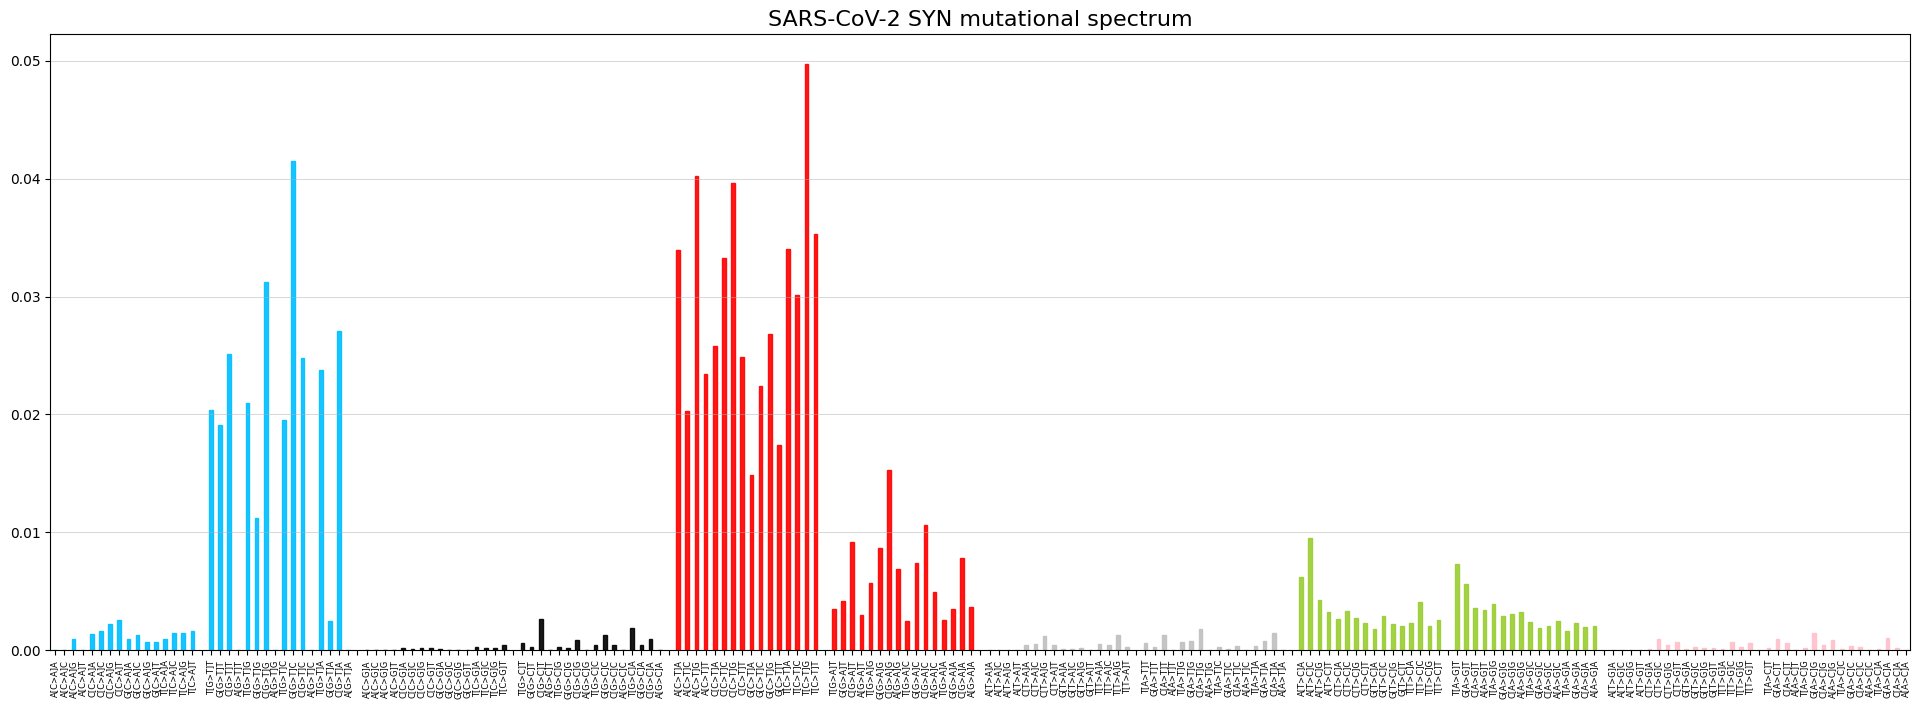

<AxesSubplot:title={'center':'SARS-CoV-2 SYN mutational spectrum'}>

In [9]:
from pymutspec.draw import plot_mutspec192

plot_mutspec192(sars_spectrum.reset_index(), title='SARS-CoV-2 SYN mutational spectrum')

## Asymmetry stuff

### Load asymmetry

In [10]:
assymetry = pd.read_table('../data/external/T-R_plot_allCpG.txt', sep=' ', header=None)
assymetry = assymetry.rename(columns={0:'AncestorCodon', 1:'MutBase', 2:'T', 3:'R'})
assymetry

,AncestorCodon,MutBase,T,R
0,ACA,C>A,-0.171181,-0.373510
1,ACA,C>G,0.065067,0.034147
2,ACA,C>T,-0.012015,-0.052744
3,ACC,C>A,-0.091167,-0.285840
4,ACC,C>G,0.091991,0.144789
...,...,...,...,...
91,TTG,T>C,-0.128221,-0.376439
92,TTG,T>G,-0.015891,-0.009426
93,TTT,T>A,0.037072,-0.047516
94,TTT,T>C,-0.154469,-0.430284


In [11]:
df_mutspec = sars_spectrum['MutSpec'].reset_index()

df_mutspec["MutBase"] = df_mutspec.Mut.str.slice(2, 5)
df_mutspec['AncestorCodon'] = df_mutspec.Mut.str.get(0) + \
                              df_mutspec.Mut.str.get(2) +\
                              df_mutspec.Mut.str.get(-1)
df_mutspec

,Mut,MutSpec,MutBase,AncestorCodon
0,T[T>G]T,0.000611,T>G,TTT
1,T[T>A]T,0.000281,T>A,TTT
2,T[T>C]T,0.002545,T>C,TTT
3,A[A>C]A,0.000000,A>C,AAA
4,A[A>G]A,0.002051,A>G,AAA
...,...,...,...,...
187,C[G>A]G,0.015329,G>A,CGG
188,C[G>T]G,0.031217,G>T,CGG
189,C[C>A]G,0.002264,C>A,CCG
190,C[C>G]G,0.000217,C>G,CCG


### Collapse 192 mtDNA mutspec to 96 component

In [14]:
transcriptor = str.maketrans("ACGT", "TGCA")

def gettranslate(mut, reverse=True):
    if reverse is True:
        mut = mut[-1] + mut[1:-1] + mut[0]
    new_mut = mut.translate(transcriptor)
    return new_mut

def transform192_to96(asymmetry_df, df_transform):
    to_96_comp = []
    for num_subs in range(0,96):
        # define ancestral and mutbase from mutspec according on 96 comp from asymmetry
        anc = asymmetry_df.loc[num_subs, 'AncestorCodon']
        sbs12 = asymmetry_df.loc[num_subs, 'MutBase']
        # get reverse subs with context
        rev_anc = gettranslate(anc, reverse=True)
        rev_sbs12 = gettranslate(sbs12, reverse=False)
        # find mutspec num for the mutbase and context same with reverse, than devide on reverse
        mutspec = df_transform[(df_transform.MutBase == sbs12) & \
                               (df_transform.AncestorCodon == anc)].MutSpec.values[0]
        rev_mutspec = df_transform[(df_transform.MutBase == rev_sbs12) & \
                                   (df_transform.AncestorCodon == rev_anc)].MutSpec.values[0]
        if rev_mutspec != 0:
            new_96_mut = mutspec/rev_mutspec
            #define row for future df
            out_mut = {'AncestorCodon': anc, 'MutBase': sbs12, 'MutSpec': new_96_mut}
            to_96_comp.append(out_mut)

    mut_96_comp = pd.DataFrame(to_96_comp)
    return(mut_96_comp)
    

In [15]:
mut_96_comp = transform192_to96(assymetry, df_mutspec)
mut_96_comp

,AncestorCodon,MutBase,MutSpec
0,ACA,C>A,0.000000
1,ACA,C>G,0.000000
2,ACA,C>T,9.623378
3,ACC,C>A,0.000000
4,ACC,C>G,0.000000
...,...,...,...
76,TTC,T>G,0.704619
77,TTG,T>A,0.924371
78,TTG,T>C,1.073745
79,TTG,T>G,1.224138


In [16]:
final_asymmetry = assymetry.merge(right = mut_96_comp, on=['AncestorCodon', 'MutBase'])
final_asymmetry = final_asymmetry[final_asymmetry.MutSpec != 0]
final_asymmetry.MutSpec = np.log2(final_asymmetry.MutSpec)
final_asymmetry.head()

,AncestorCodon,MutBase,T,R,MutSpec
2,ACA,C>T,-0.012015,-0.052744,3.266543
5,ACC,C>T,0.028556,-0.069531,2.289641
6,ACG,C>A,-0.127277,-0.412694,-4.736966
8,ACG,C>T,0.071747,0.012317,2.132227
9,ACT,C>T,-0.088058,-0.074512,2.983244


### What is the per for C>T symmetry part and all TV

In [17]:
TV_vec = ['A>T', 'T>A', 'C>G', 'G>C', 'C>A', 'A>C', 'T>G', 'G>T']

In [18]:
print(f"Sum of symmetrycal part of C>T plus all trasversions is {sum(df_mutspec[df_mutspec.MutBase.isin(TV_vec)].MutSpec.values) + sum(df_mutspec[df_mutspec.MutBase == 'G>A'].MutSpec.values) * 2}")

Sum of symmetrycal part of C>T plus all trasversions is 0.5230060423483494


In [19]:
sum(df_mutspec[df_mutspec.MutBase.isin(TV_vec)].MutSpec.values)

0.3239046452377772

In [20]:
sum(df_mutspec[df_mutspec.MutBase == 'G>A'].MutSpec.values) * 2

0.19910139711057218

### Define C>T and A>G asymmetry from all mutations in mutspec

C>T

In [21]:
df_mutspec.head()

,Mut,MutSpec,MutBase,AncestorCodon
0,T[T>G]T,0.000611,T>G,TTT
1,T[T>A]T,0.000281,T>A,TTT
2,T[T>C]T,0.002545,T>C,TTT
3,A[A>C]A,0.000000,A>C,AAA
4,A[A>G]A,0.002051,A>G,AAA


In [22]:
asymmetry_CT_val = 0
for mut in df_mutspec[df_mutspec.MutBase == 'C>T'].Mut.values:
    CT_val = df_mutspec[df_mutspec.Mut == mut].MutSpec.values[0]
    rev_mut = gettranslate(mut)
    GA_val = df_mutspec[df_mutspec.Mut == rev_mut].MutSpec.values[0]
    asymmetry_CT_val += (CT_val - GA_val)

asymmetry_CT_val / sum(df_mutspec.MutSpec.values)

0.3726021660127987

Now A>G

In [23]:
asymmetry_AG_val = 0
for mut in df_mutspec[df_mutspec.MutBase == 'A>G'].Mut.values:
    AG_val = df_mutspec[df_mutspec.Mut == mut].MutSpec.values[0]
    rev_mut = gettranslate(mut)
    TC_val = df_mutspec[df_mutspec.Mut == rev_mut].MutSpec.values[0]
    asymmetry_AG_val += (AG_val - TC_val)

asymmetry_AG_val / sum(df_mutspec.MutSpec.values)

-0.004266121527716994

### Complete cor test for t and r asymmetry and mtDNA mutSpec

In [24]:
t_cor = stats.spearmanr(final_asymmetry['T'].values, final_asymmetry.MutSpec.values, axis=0)
t_cor

SpearmanrResult(correlation=0.1999269272926562, pvalue=0.09954710783463039)

In [25]:
r_cor = stats.spearmanr(final_asymmetry['R'].values, final_asymmetry.MutSpec.values)
r_cor

SpearmanrResult(correlation=0.20047497259773475, pvalue=0.09860346702937255)

### Draw plot for T and R asymmetry and mutspec

In [26]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

In [27]:
final_asymmetry = final_asymmetry.rename(columns={'MutBase':'Mutation Base'})

Text(0.5, 0.01, 'log2[mtDNA Mutational Spectrum Asymmetry]')

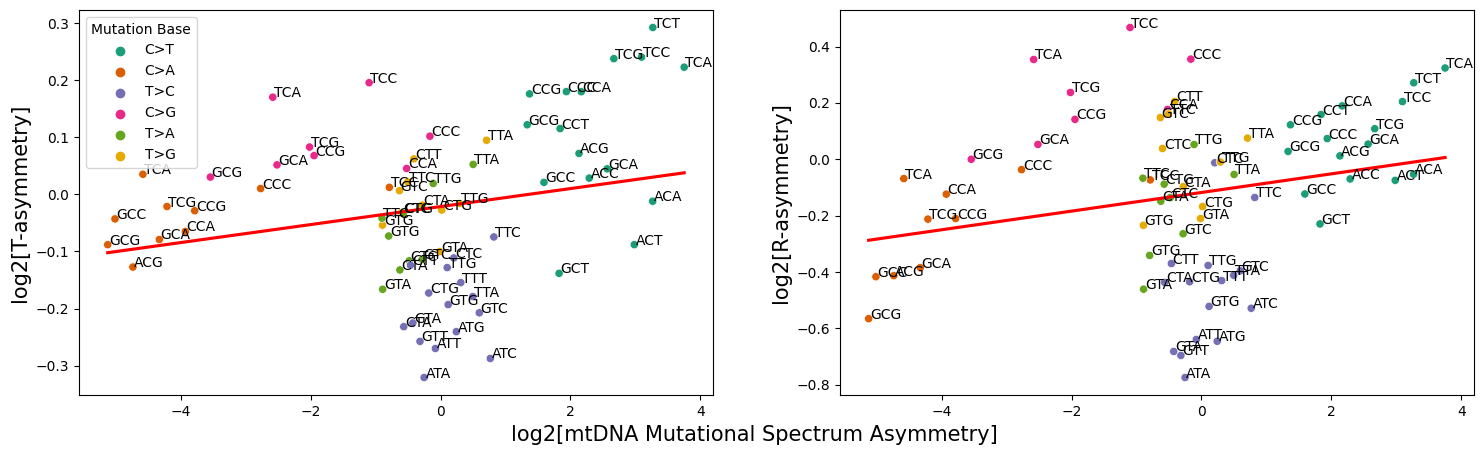

In [28]:
fig, axes = plt.subplots(1,2, sharex=True, figsize=(18,5))

sns.scatterplot(data = final_asymmetry, x='MutSpec', y='T', hue='Mutation Base', ax=axes[0], palette='Dark2')
label_point(final_asymmetry.MutSpec, final_asymmetry['T'], final_asymmetry.AncestorCodon, axes[0])
sns.regplot(data=final_asymmetry, x='MutSpec', y='T', ci=None, scatter=False,color='red', ax=axes[0])
#axes[0].legend([],[], frameon=False)
# axes[0].set_xlim(-3.2,3.2)
# axes[0].set_ylim(-0.35,0.35)
axes[0].set_xlabel('')
axes[0].set_ylabel('log2[T-asymmetry]', size=15)


sns.scatterplot(data = final_asymmetry, x='MutSpec', y='R', hue='Mutation Base', ax=axes[1], palette='Dark2')
label_point(final_asymmetry.MutSpec, final_asymmetry['R'], final_asymmetry.AncestorCodon, axes[1])
sns.regplot(data=final_asymmetry, x='MutSpec', y='R', ci=None, scatter=False,color='red', ax=axes[1])
axes[1].legend([],[], frameon=False)
# axes[1].set_xlim(-3.2,3.2)
# axes[1].set_ylim(-0.9,0.9)
axes[1].set_xlabel('')
axes[1].set_ylabel('log2[R-asymmetry]', size = 15)
fig.supxlabel('log2[mtDNA Mutational Spectrum Asymmetry]', size=15)
# fig.savefig('../pictures/AsymmetryTRM.pdf', dpi=300)

In [29]:
#final_asymmetry.to_csv('../data/asymmetry_mutspec.csv', index=False)

### Error bar for mtDNA MutSpec asymmetry

In [30]:
err_dt = final_asymmetry.groupby('Mutation Base').agg(
    T_mean = pd.NamedAgg(column='T', aggfunc='mean'),
    T_sd = pd.NamedAgg(column='T', aggfunc='std'),
    R_mean = pd.NamedAgg(column='R', aggfunc='mean'),
    R_sd = pd.NamedAgg(column='R', aggfunc='std'),
    mut_mean = pd.NamedAgg(column='MutSpec', aggfunc='mean'),
    mut_sd = pd.NamedAgg(column='MutSpec', aggfunc='std')).reset_index()

In [31]:
err_dt

,Mutation Base,T_mean,T_sd,R_mean,R_sd,mut_mean,mut_sd
0,C>A,-0.039431,0.051085,-0.250195,0.182781,-3.927160,1.297487
1,C>G,0.093243,0.060006,0.223431,0.161325,-1.799281,1.136637
2,C>T,0.105891,0.123658,0.062509,0.149783,2.380567,0.734498
3,T>A,-0.067207,0.072658,-0.167339,0.159896,-0.462691,0.449079
4,T>C,-0.198624,0.069060,-0.468007,0.201173,0.085776,0.438785
5,T>G,-0.006293,0.056089,-0.008840,0.160916,-0.231855,0.484553


In [32]:
# sort MutBase values as in scatter plot
err_dt['Mutation Base'] = pd.Categorical(err_dt['Mutation Base'], ['C>T', 'T>C', 'C>A', 'C>G', 'T>A', 'T>G'])
err_dt = err_dt.sort_values(['Mutation Base'])

In [33]:
err_dt

,Mutation Base,T_mean,T_sd,R_mean,R_sd,mut_mean,mut_sd
2,C>T,0.105891,0.123658,0.062509,0.149783,2.380567,0.734498
4,T>C,-0.198624,0.069060,-0.468007,0.201173,0.085776,0.438785
0,C>A,-0.039431,0.051085,-0.250195,0.182781,-3.927160,1.297487
1,C>G,0.093243,0.060006,0.223431,0.161325,-1.799281,1.136637
3,T>A,-0.067207,0.072658,-0.167339,0.159896,-0.462691,0.449079
5,T>G,-0.006293,0.056089,-0.008840,0.160916,-0.231855,0.484553


Text(0.5, 0.01, 'log2[mtDNA Mutational Spectrum Asymmetry]')

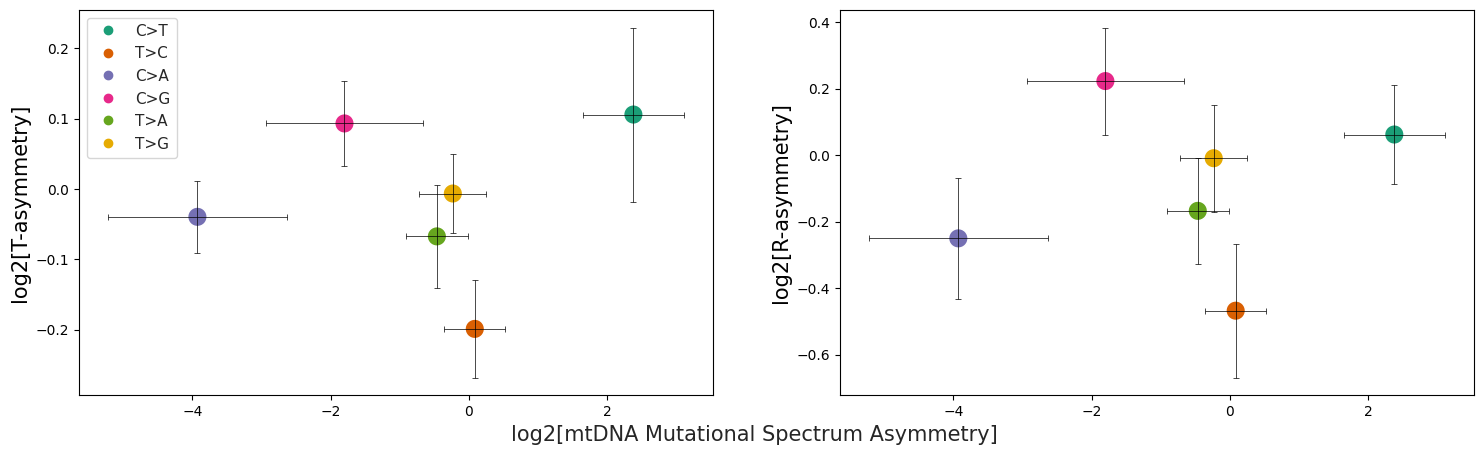

In [34]:
fig, axes = plt.subplots(1,2, sharex=False, figsize=(18,5))
sns.set_style("ticks")

sns.scatterplot(y="T_mean", x="mut_mean", data=err_dt, palette="Dark2", 
                hue='Mutation Base', s=200, ax=axes[0])
axes[0].errorbar(y="T_mean", x="mut_mean", xerr='mut_sd', yerr='T_sd', fmt='None', elinewidth=0.5, 
             data=err_dt, label=None, capsize=2, capthick=0.5, ecolor='black')

axes[0].tick_params(axis='x')
axes[0].legend(loc='upper left', scatteryoffsets=[0.55], frameon=True, fontsize=11, ncol=1)
# axes[0].set_xlim(-3.2,3.2)
# axes[0].set_ylim(-0.35,0.35)
axes[0].set_xlabel("")
axes[0].set_ylabel("log2[T-asymmetry]", fontsize=15)


sns.scatterplot(y="R_mean", x="mut_mean", data=err_dt, palette="Dark2", 
                hue='Mutation Base', s=200, ax=axes[1])
axes[1].errorbar(y="R_mean", x="mut_mean", xerr='mut_sd', yerr='R_sd', fmt='None', elinewidth=0.5, 
             data=err_dt, label=None, capsize=2, capthick=0.5, ecolor='black')

axes[1].tick_params(axis='x')
axes[1].legend([],[], frameon=False)
# axes[1].set_xlim(-3.2,3.2)
# axes[1].set_ylim(-0.9,0.9)
axes[1].set_xlabel("")
axes[1].set_ylabel("log2[R-asymmetry]", fontsize=15)

fig.supxlabel('log2[mtDNA Mutational Spectrum Asymmetry]', size=15)
# fig.savefig("../pictures/AsymmetryErrorBars.pdf", dpi=300)

### Six types of base substitutions


In [35]:
bs_subs = ['C>A', 'T>A', 'C>G', 'T>C', 'C>T', 'T>G']

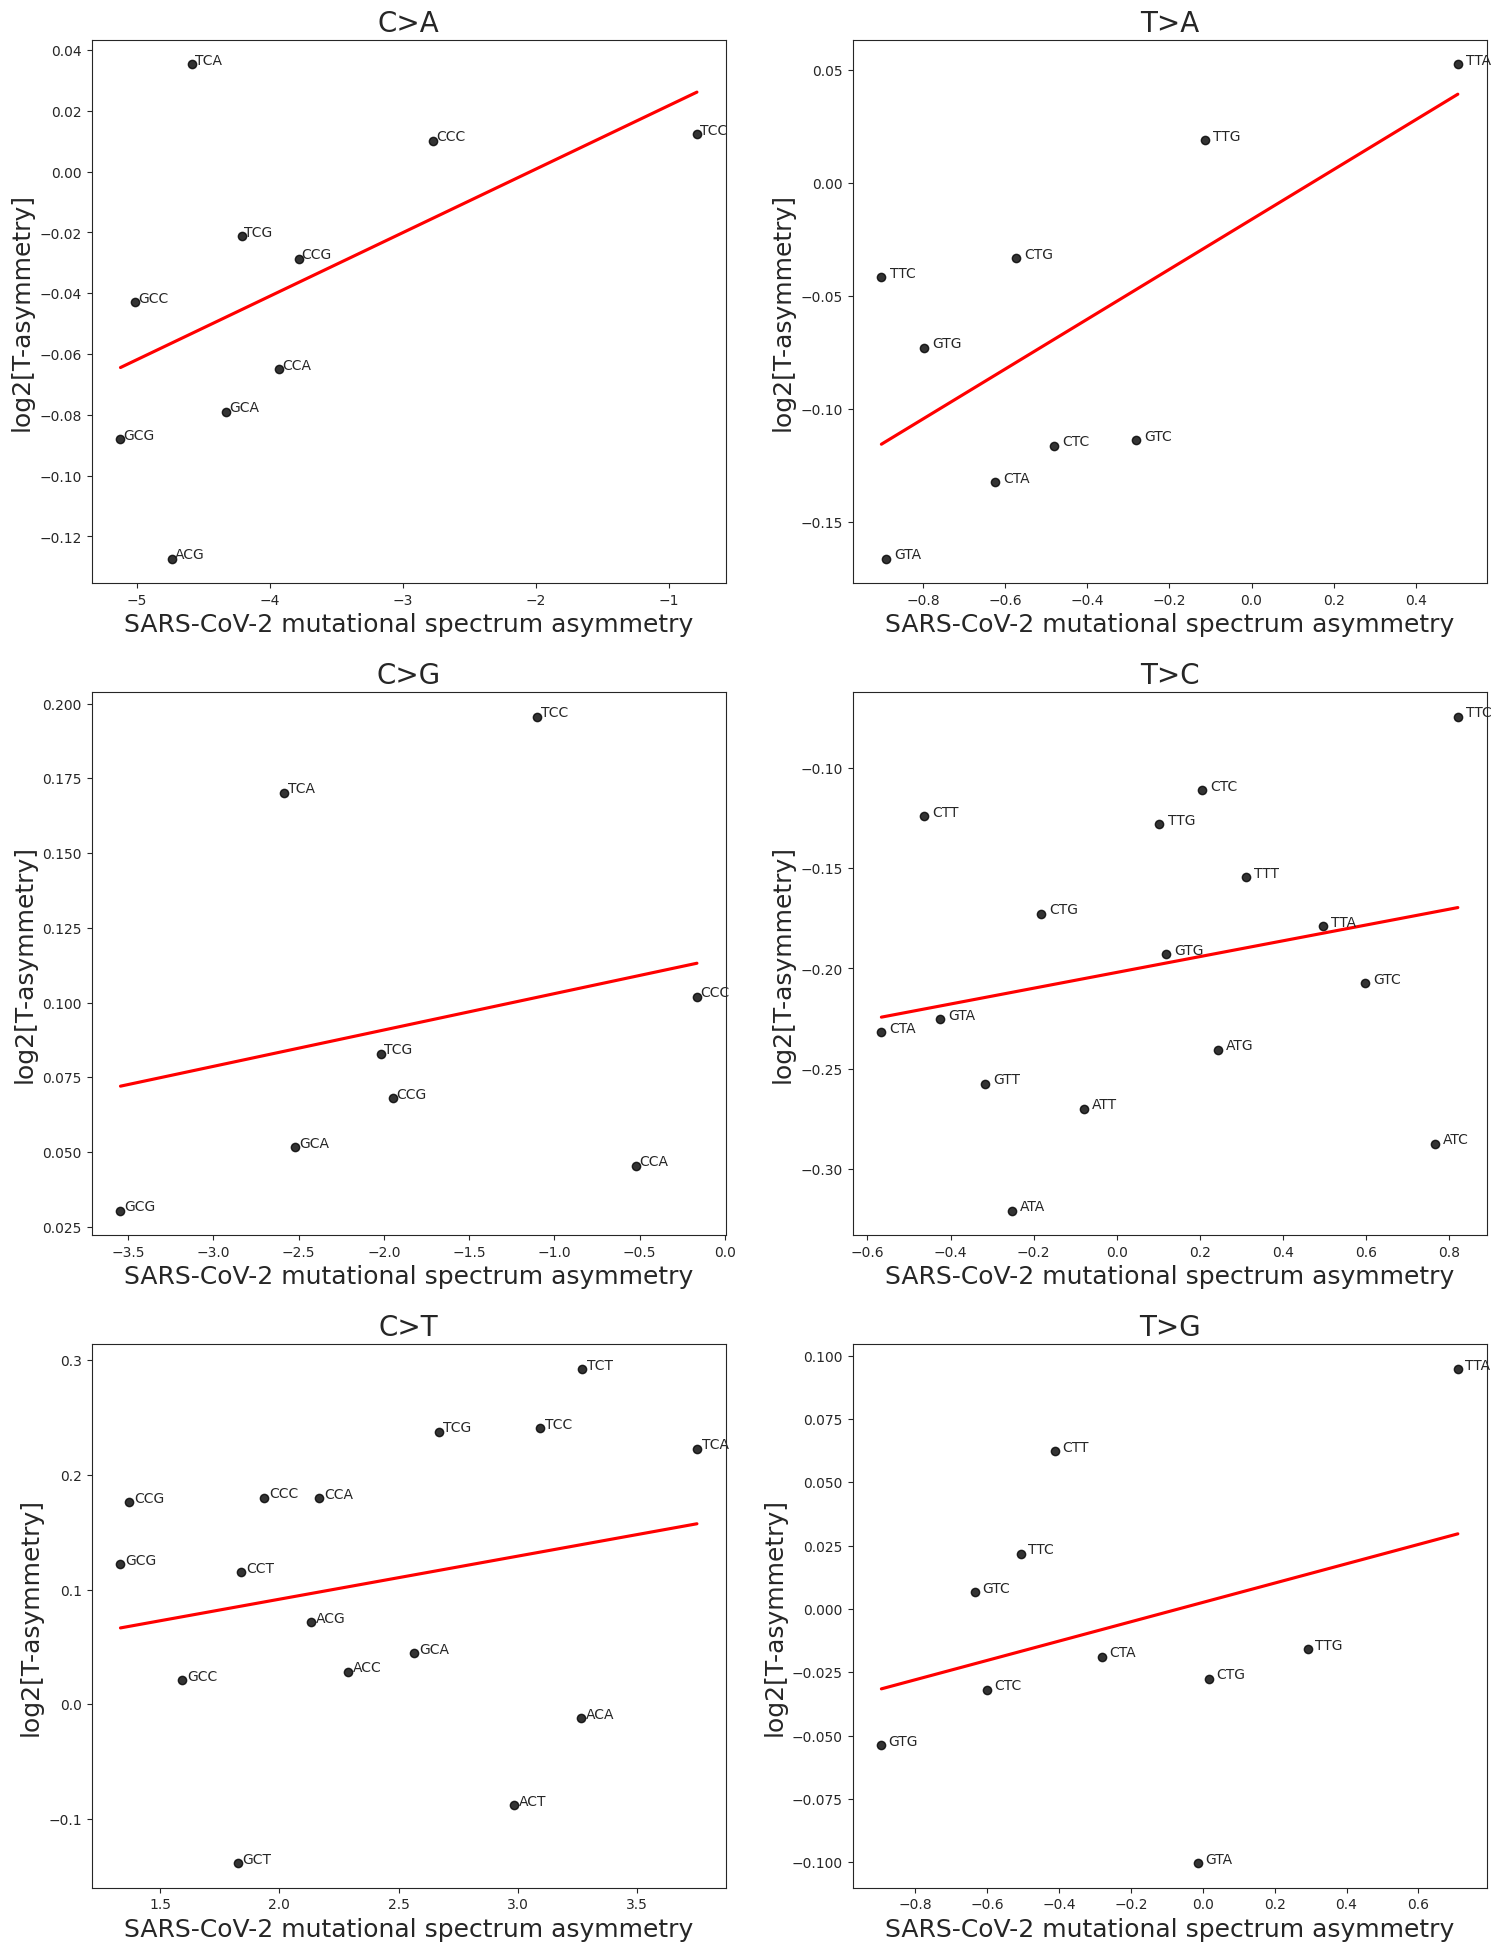

In [36]:
fig, axes = plt.subplots(3,2, sharex=False, figsize=(18,24))

for sub, ax in zip(bs_subs, axes.ravel()):
    to_draw = final_asymmetry[final_asymmetry['Mutation Base'] == sub]
    sns.regplot(data = to_draw, x='MutSpec', y='T', ax=ax, ci=None, 
                scatter_kws={"color": "black"}, line_kws={"color": "red"})
    label_point(to_draw.MutSpec, to_draw['T'], to_draw.AncestorCodon, ax)
    ax.set_title(sub, fontsize=20)
    ax.set_xlabel('SARS-CoV-2 mutational spectrum asymmetry', fontsize=18)
    ax.set_ylabel('log2[T-asymmetry]', fontsize=18)
#fig.savefig('../pictures/AsymmetryMutBaseT.pdf', dpi=300)

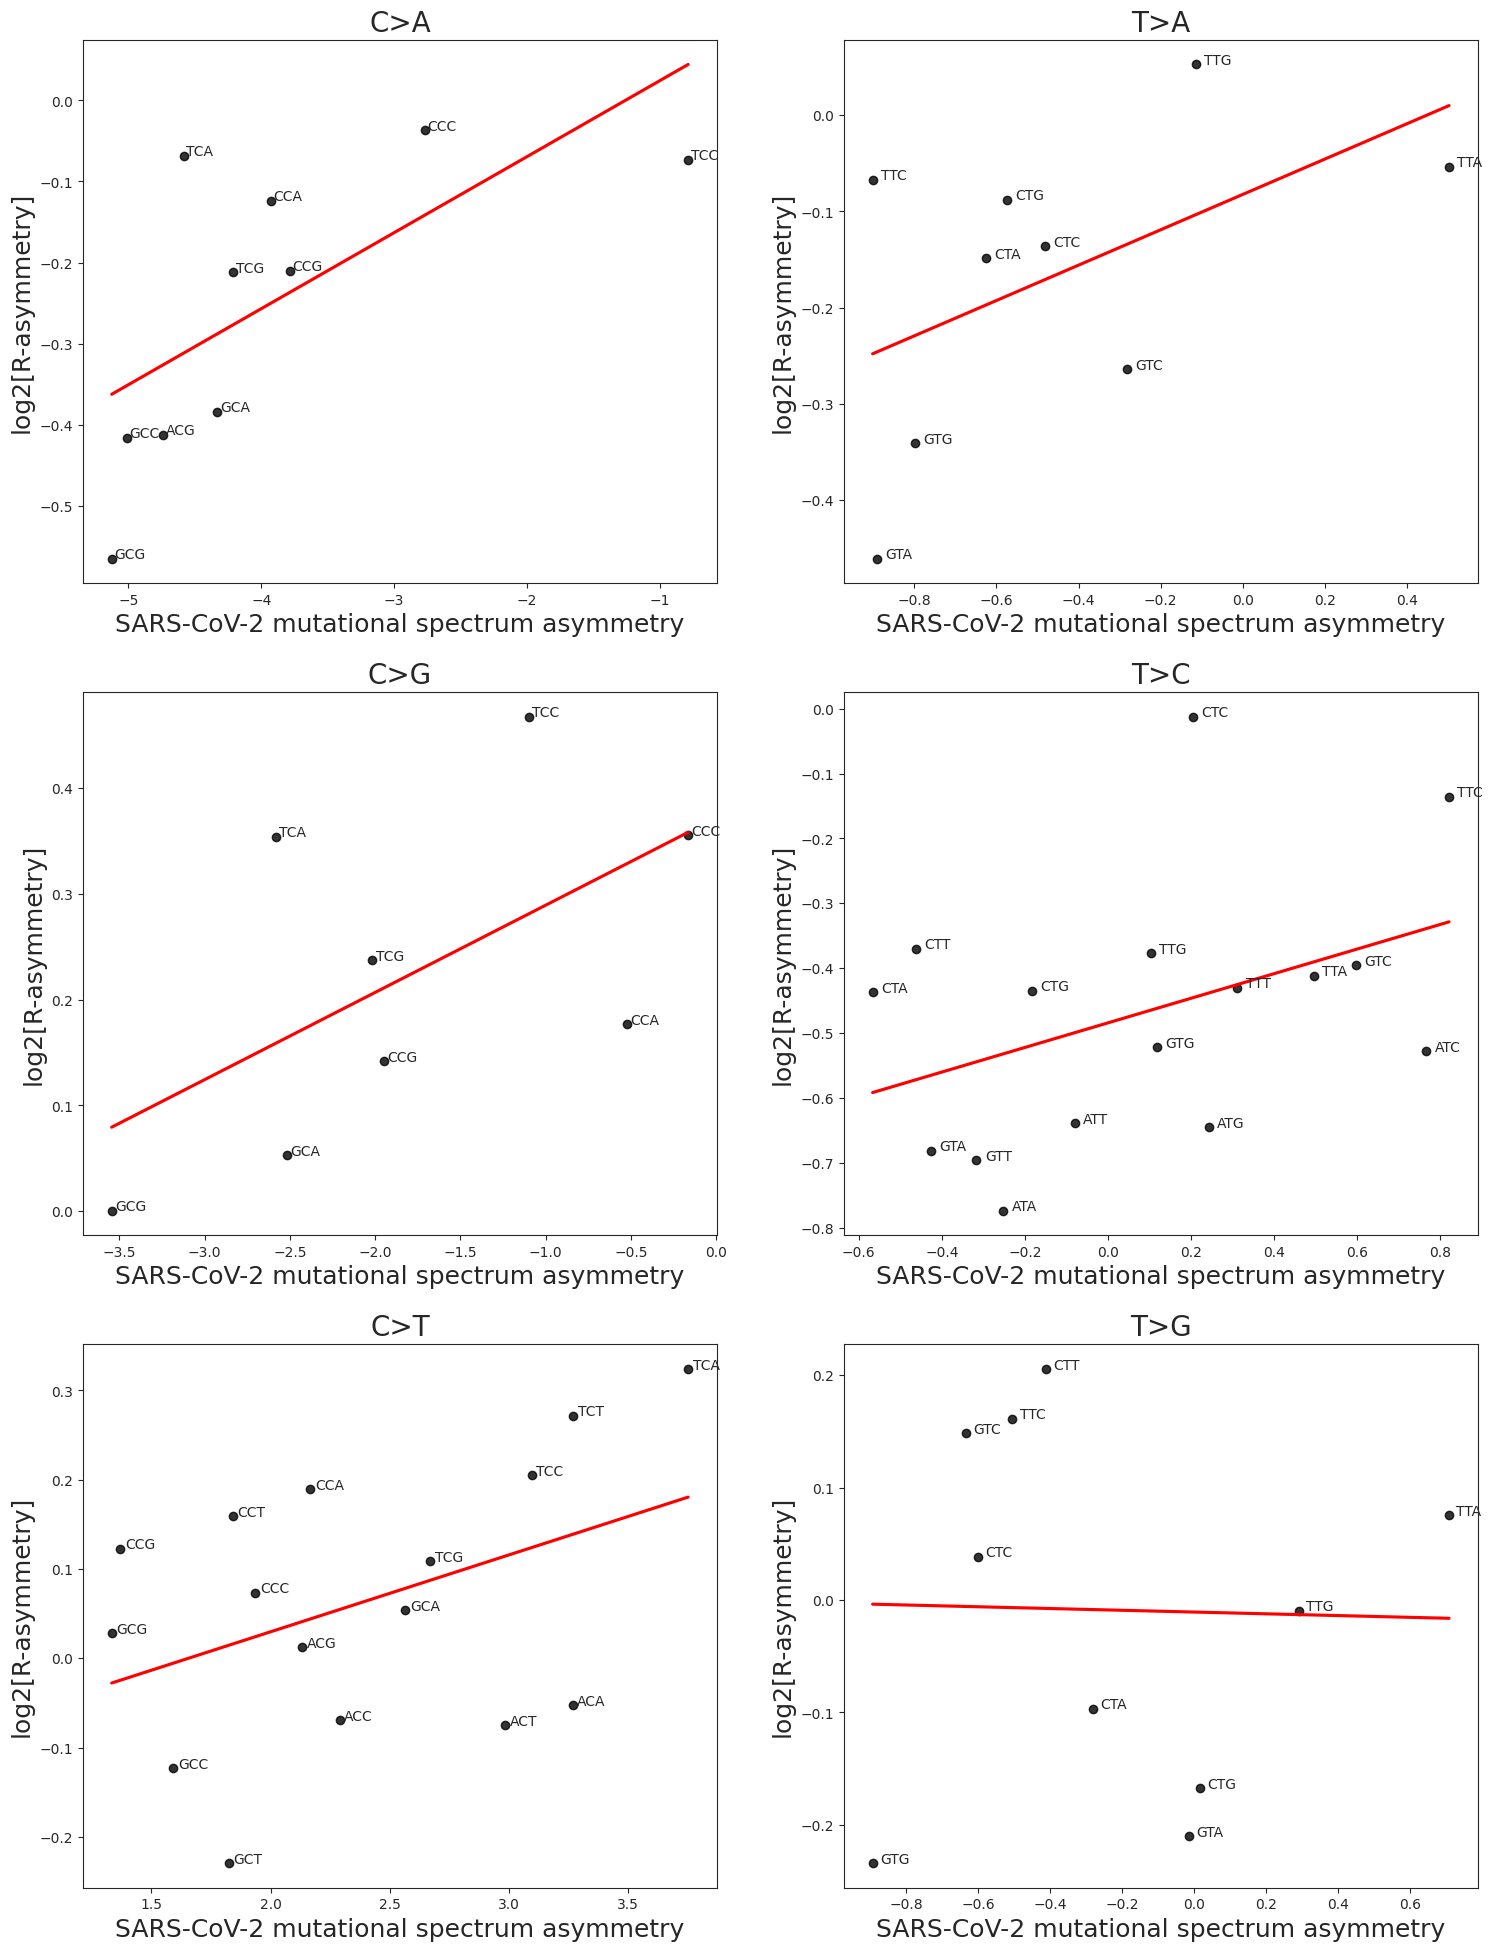

In [37]:
fig, axes = plt.subplots(3,2, sharex=False, figsize=(18,24))

for sub, ax in zip(bs_subs, axes.ravel()):
    to_draw = final_asymmetry[final_asymmetry['Mutation Base'] == sub]
    sns.regplot(data = to_draw, x='MutSpec', y='R', ax=ax, ci=None, 
                scatter_kws={"color": "black"}, line_kws={"color": "red"})
    label_point(to_draw.MutSpec, to_draw['R'], to_draw.AncestorCodon, ax)
    ax.set_title(sub, fontsize=20)
    ax.set_xlabel('SARS-CoV-2 mutational spectrum asymmetry', fontsize=18)
    ax.set_ylabel('log2[R-asymmetry]', fontsize=18)
#fig.savefig('../pictures/AsymmetryMutBaseR.pdf', dpi=300)

### Made cor test with spearman for each combination of R/T and MutSpec

In [38]:
cor_res = []
for sub in bs_subs:
    to_cor = final_asymmetry[final_asymmetry['Mutation Base'] == sub]
    T_cor = stats.spearmanr(to_cor['T'].values, to_cor.MutSpec.values, axis=0)
    R_cor = stats.spearmanr(to_cor['R'].values, to_cor.MutSpec.values, axis=0)
    out_line = {'MutBase': sub, 'T_asymmetry_cor': T_cor.correlation, 'R_asymmetry_cor': R_cor.correlation}
    cor_res.append(out_line)
cor_res = pd.DataFrame(cor_res)
cor_res

,MutBase,T_asymmetry_cor,R_asymmetry_cor
0,C>A,0.575758,0.781818
1,T>A,0.533333,0.516667
2,C>G,0.285714,0.571429
3,T>C,0.202941,0.361765
4,C>T,0.311765,0.405882
5,T>G,0.272727,-0.054545


### Damage analysis

In [39]:
main_subs = ['C>T', 'A>G', 'G>T', 'A>T', 'C>G', 'A>C']

In [40]:
damage = []
for mutbase in main_subs:
    cont_mb = df_mutspec[df_mutspec.MutBase == mutbase].Mut
    for context in cont_mb:
        mutspec_main = df_mutspec[df_mutspec.Mut == context].MutSpec.values[0]
        mutspec_rev = df_mutspec[df_mutspec.Mut == gettranslate(context, reverse=True)].MutSpec.values[0]
        out_damage = {'Mut':context,'ReverseMut':gettranslate(context, reverse=True), 'MutSpecDif':mutspec_main-mutspec_rev, 'MutBase': mutbase}
        damage.append(out_damage)
damage = pd.DataFrame(damage)
damage.head()

,Mut,ReverseMut,MutSpecDif,MutBase
0,A[C>T]A,T[G>A]T,0.030390,C>T
1,A[C>T]T,A[G>A]T,0.020506,C>T
2,T[C>T]A,T[G>A]A,0.031492,C>T
3,T[C>T]T,A[G>A]A,0.031635,C>T
4,G[C>T]T,A[G>A]C,0.012474,C>T


In [41]:
damage[damage.MutBase == 'C>T'].MutSpecDif.sum()

0.3726021660127988

In [42]:
damage.MutSpecDif.sum()

0.6144721051696462